In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, VotingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import recall_score, accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import StackingClassifier

from sklearn.impute import SimpleImputer

from mpl_toolkits import mplot3d

In [4]:
pd.set_option('display.max_columns', None)
X = pd.read_csv('../../../data/trainingsetvalues.csv')
y_full = pd.read_csv('../../../data/trainingsetlabels.csv')

In [5]:
X.funder = X.funder.replace(np.nan, 'Unknown')
X.installer = X.installer.replace(np.nan, 'Unknown')
X.permit = X.permit.replace(np.nan, False)

In [6]:
y_full = y_full.drop(columns = 'id')

In [7]:
y_full.status_group.loc[y_full.status_group == 'functional'] = 1
y_full.status_group.loc[y_full.status_group != 1] = 0
y_full = y_full.astype(int)

In [8]:
droplist = ['wpt_name', 'subvillage', 'num_private', 'scheme_name', 'recorded_by', 'scheme_management', 'management', 'extraction_type', 
            'payment', 'extraction_type_class', 'quality_group', 'quantity_group', 'source', 'source_class', 'waterpoint_type_group', 'ward',
           'region_code', 'district_code', 'public_meeting', 'funder', 'lga', 'management_group']

X_clean_full = X.drop(columns = droplist, axis=1)

# Filled in Zero's for the gps_height column

In [9]:
dodoma_idx = X_clean_full[X_clean_full.region == 'Dodoma'].index
X_clean_full.at[dodoma_idx, 'gps_height'] = 1350

In [10]:
kagera_idx = X_clean_full[X_clean_full.region == 'Kagera'].index
X_clean_full.at[kagera_idx, 'gps_height'] = 1450

In [11]:
mbeya_idx = X_clean_full[X_clean_full.region == 'Mbeya'].index
X_clean_full.at[mbeya_idx, 'gps_height'] = 1715

In [12]:
tabora_idx = X_clean_full[X_clean_full.region == 'Tabora'].index
X_clean_full.at[tabora_idx, 'gps_height'] = 1200

In [13]:
shinyanga_idx = X_clean_full[X_clean_full.region == 'Shinyanga'].index
X_clean_full.at[shinyanga_idx, 'gps_height'] = 1162

In [14]:
mwanza_idx = X_clean_full[X_clean_full.region == 'Mwanza'].index
X_clean_full.at[mwanza_idx, 'gps_height'] = 1200

# Created a new age column

In [15]:
years = [int(X_clean_full['date_recorded'][x][:4]) for x in range(len(X_clean_full['date_recorded']))]
X_clean_full['date_recorded'] = years

In [16]:
X_clean_full.construction_year = X_clean_full.construction_year.replace(0, 2000)

In [17]:
X_clean_full['age'] = X_clean_full['date_recorded'] - X_clean_full['construction_year']

# Cleaned up the Installer Column

In [18]:
top_installers = list(X_clean_full.installer.value_counts()[:7].index)
top_installers

['DWE', 'Unknown', 'Government', 'RWE', 'Commu', 'DANIDA', 'KKKT']

In [19]:
X_clean_full.installer.loc[~X_clean_full['installer'].isin(top_installers)] = 'Other'

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


# TT Split

In [184]:
X_clean, X_test, y, y_test = train_test_split(X_clean_full, y_full, random_state=1)

# Made a function for returning catagorical and numerical columns

In [21]:
def cleaning(data):
    cat_cols = list(data.select_dtypes('object'))
    numeric_cols = list(data.select_dtypes('number'))
    cat_df = pd.DataFrame(data[cat_cols])
    numeric_df = pd.DataFrame(data[numeric_cols])
    return cat_df, numeric_df

# Split into categorical and numerical

In [22]:
X_cats, X_nums = cleaning(X_clean)
X_cats_test, X_nums_test = cleaning(X_test)
X_nums.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)
X_nums_test.drop(columns = ['longitude', 'latitude', 'id'], inplace=True)

# One hot encoder and scaler

In [23]:
ohe = OneHotEncoder(sparse=False)
ohe.fit(X_cats)
X_cats_ohe = pd.DataFrame(ohe.transform(X_cats), columns = ohe.get_feature_names(input_features = X_cats.columns))
X_cats_ohe_test = pd.DataFrame(ohe.transform(X_cats_test), columns = ohe.get_feature_names(input_features = X_cats_test.columns))

In [24]:
ss = StandardScaler()
ss.fit(X_nums)
X_nums_scaled = pd.DataFrame(ss.transform(X_nums), columns = X_nums.columns)
X_nums_scaled_test = pd.DataFrame(ss.transform(X_nums_test), columns = X_nums_test.columns)

In [25]:
X_data = pd.concat((X_nums_scaled, X_cats_ohe), axis=1)
X_data_test = pd.concat((X_nums_scaled_test, X_cats_ohe_test), axis=1)

# Our class for testing data features on our model

In [169]:
class Model:
    
    def __init__(self, model, y):
        self.model = model
        self.y = np.array(y).ravel()
        self.columns = ['f1 score', 'accuracy_score', 'Notes']
        self.df = pd.DataFrame(columns = self.columns)
        
    def model_history(self, X, notes, y_new=pd.DataFrame()):
        if y_new.empty==True:
            y_new = self.y
        
        f1_score_ = cross_val_score(self.model, X, cv=3, scoring = 'f1', y=y_new)
        accuracy_score_ = cross_val_score(self.model, X, cv=3, scoring='accuracy', y=y_new)
        frame = pd.DataFrame([[f1_score_.mean(), accuracy_score_.mean(), notes]], columns=self.columns)
        self.df = self.df.append(frame).reset_index(drop=True)
#       self.df = self.df.sort_values('f1 score', ascending=False)
        return self.df

    def error_vis(self, X, y_new=pd.DataFrame()):
        if y_new.empty==True:
            y_new = self.y
        self.model.fit(X, y_new)
        sns.set(rc = {'figure.figsize':(10,6)})
        sns.distplot((np.array(y_new).ravel() - self.model.predict_proba(X)[:,1]),
            color='blue', bins=25, kde_kws = {'color':'red'})
        

### Function for removing one hot encoded catagories from a DataFrame

In [27]:
def remove_column(col):
    remove_list = []
    for x in X_data.columns:
        if col in x:
            remove_list.append(x)
    X_data_new = X_data.drop(columns = remove_list)
    return X_data_new

# Our Models

In [28]:
rf_2 = RandomForestClassifier(max_depth = 18, min_samples_split = 15, n_estimators = 50, random_state = 1)
xgb = XGBClassifier(max_depth = 8, gamma =0.5, tree_method='hist', eta=.295, verbosity=0)
estimators = [
    ('xg', XGBClassifier(max_depth = 8, gamma =0.5, tree_method='hist', eta=.295)),
    ('rf', RandomForestClassifier(max_depth = 18, min_samples_split = 15, n_estimators = 50))
]

stacked_model = StackingClassifier(estimators)

## Base Model with no engineering

In [172]:
rf_tester = Model(rf_2, y)
xgb_tester = Model(xgb, y)

In [30]:
rf_tester.model_history(X_data, notes= 'Base model with standard feature engineering')
xgb_tester.model_history(X_data, notes= 'Base model with standard feature engineering')

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering


In [176]:
xgb_error_vis = XGBClassifier(max_depth = 8, gamma =0.5, tree_method='hist', eta=.295, verbosity=0)

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


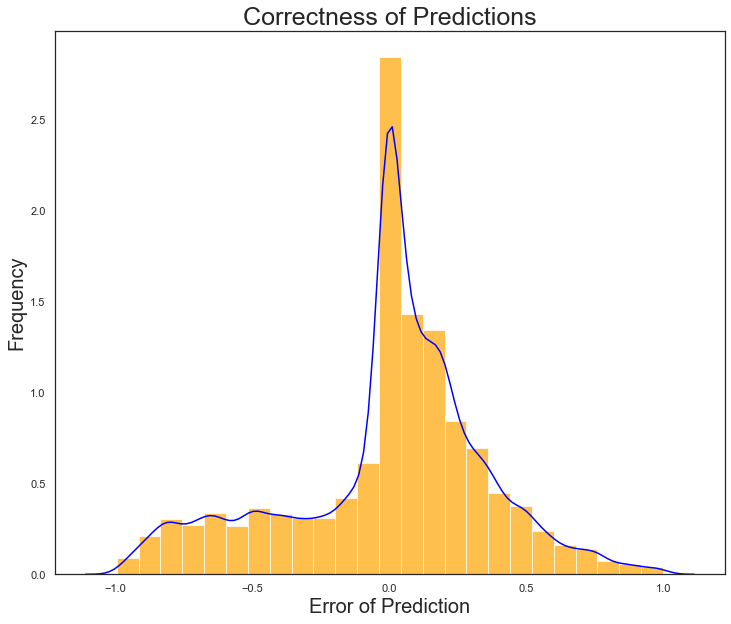

In [224]:
xgb_error_vis.fit(X_data, y)
fig, ax = plt.subplots(figsize=(12,10))
sns.set(rc = {'figure.figsize':(10,6)}, style='white')
sns.distplot((np.array(y_test).ravel() - xgb_error_vis.predict_proba(X_data_test)[:,1]),
    color='blue', bins=25, kde_kws = {'color':'blue'}, hist_kws = {'color':'orange', 'alpha':.7})
ax.set_title('Correctness of Predictions', fontsize=25)
ax.set_xlabel('Error of Prediction', fontsize=20);
ax.set_ylabel('Frequency', fontsize=20);

plt.savefig('../../../data/XGB_Model_Error.png')

## Testing the model with only data it guessed correctly

### (This was a total failure)

In [31]:
# def modeling_function(model, X_train, y_train, X_val, y_val):

#     # fit model on training data
#     y_train = np.array(y_train).ravel()
#     y_val = np.array(y_val).ravel()

#     model.fit(X_train, y_train)

#     # make predictions on training and validation data
#     train_preds = model.predict(X_train)
#     val_preds = model.predict(X_val)

#     # Print accuracy score
    
#     train_acc = accuracy_score(y_train, train_preds).round(3)
#     val_acc = accuracy_score(y_val, val_preds).round(3)
#     train_f1 = f1_score(y_train, train_preds).round(3)
#     val_f1 = f1_score(y_val, val_preds).round(3)
    
#     print('----------------------------------------------------')
#     print('Accuracy Score:')
#     print('Training score: ', accuracy_score(y_train, train_preds).round(3))
#     print('Validation score: ', accuracy_score(y_val, val_preds).round(3))
#     print('----------------------------------------------------')
    
#     print('----------------------------------------------------')
#     print('f1 Score:')
#     print('Training score: ', f1_score(y_train, train_preds).round(3))
#     print('Validation score: ', f1_score(y_val, val_preds).round(3))
#     print('----------------------------------------------------')

In [32]:
# X_train_err, X_test_err, y_train_err, y_test_err = train_test_split(X_data, y, random_state=1)

In [33]:
# error_df = pd.DataFrame()
# error_df = pd.concat((pd.DataFrame(np.array(y_train).ravel()), pd.DataFrame(rf_err.predict_proba(X_train))), axis=1)
# error_df.set_index(X_train_err.index, inplace=True)
# error_df['prediction'] = rf_err.predict(X_train_err)
# error_df.columns = ['True Value', 'P: Broke', 'P: Works', 'Prediction']

# error_df['Correct?'] = (error_df['Prediction'] == error_df['True Value'])
# error_df['Percent Wrong'] = np.array(y_train).ravel() - rf_err.predict_proba(X_train_err)[:,1]
# error_df['Percent Wrong'] = error_df['Percent Wrong'].map(abs)*100

# correct_error_df = error_df.loc[(error_df['Percent Wrong'] < 50)]
# incorrect_error_df = error_df.loc[(error_df['Percent Wrong'] >= 50)]

# correct_indexes = correct_error_df.index
# incorrect_indexes = incorrect_error_df.index

# correct_X = X_train_err.drop(index=incorrect_indexes)
# correct_y = y_train.drop(index=incorrect_indexes)

# incorrect_X = X_train_err.drop(index=correct_indexes)
# incorrect_y = y_train.drop(index=correct_indexes)


In [34]:
# poop = RandomForestClassifier(max_depth = 16, min_samples_split = 2, n_estimators = 100, random_state = 1)

In [35]:
# modeling_function(poop, correct_X, correct_y, X_test, y_test)

In [36]:
# modeling_function(poop, correct_X, correct_y, incorrect_X, incorrect_y)

## Dropping Construction Year and Date Recorded

In [37]:
X_data_1 = X_data.drop(columns = ['date_recorded', 'construction_year'])

In [38]:
rf_tester.model_history(X_data_1, notes='Removed Date Recorded and Construction Year')
xgb_tester.model_history(X_data_1, notes='Removed Date Recorded and Construction Year')

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering
1,0.824264,0.798608,Removed Date Recorded and Construction Year


## Dropping just Construction Year

In [39]:
X_data_2 = X_data.drop(columns = 'construction_year')

In [40]:
rf_tester.model_history(X_data_2, notes='Removed Construction Year')
xgb_tester.model_history(X_data_2, notes='Removed Construction Year')

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering
1,0.824264,0.798608,Removed Date Recorded and Construction Year
2,0.824365,0.798855,Removed Construction Year


## Dropping Basin Data

In [41]:
X_data_3 = remove_column('basin')

In [42]:
rf_tester.model_history(X_data_3, notes='Removed basin column')
xgb_tester.model_history(X_data_3, notes='Removed basin column')

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering
1,0.824264,0.798608,Removed Date Recorded and Construction Year
2,0.824365,0.798855,Removed Construction Year
3,0.823611,0.797621,Removed basin column


## Being more specific with extraction type

In [43]:
X_data_4_raw = X_data.copy()
X_data_4_col = X[['extraction_type']].iloc[X_data.index]

In [44]:
ohe2 = OneHotEncoder(sparse=False)
ohe2.fit(X_data_4_col)
X_data_4_ohe = pd.DataFrame(ohe2.transform(X_data_4_col), columns = ohe2.get_feature_names(input_features = X_data_4_col.columns))
X_data_4_old = pd.concat((X_data_4_raw.reset_index(), X_data_4_ohe.reset_index()), axis=1)

In [45]:
ex_group_remove_list = []
for x in X_data_4_old.columns:
    if 'extraction_type_group_' in x:
        ex_group_remove_list.append(x)
X_data_4 = X_data_4_old.drop(columns = ex_group_remove_list)

In [46]:
rf_tester.model_history(X_data_4, notes='Replaced Extraction Group with Extraction Type')

,f1 score,accuracy_score,Notes
0,0.827040,0.797262,Base model with standard feature engineering
1,0.826764,0.796431,Removed Date Recorded and Construction Year
2,0.826684,0.795578,Removed Construction Year
3,0.826273,0.795735,Removed basin column
4,0.765611,0.754411,Replaced Extraction Group with Extraction Type


## Dropping the first row of each encoded variable

In [47]:
ohe3 = OneHotEncoder(sparse=False, drop='first')
ohe3.fit(X_cats)
X_5_cats_ohe = pd.DataFrame(ohe3.transform(X_cats), columns = ohe3.get_feature_names(input_features = X_cats.columns))

In [48]:
X_data_5 = pd.concat((X_nums_scaled, X_5_cats_ohe), axis=1)

In [49]:
rf_tester.model_history(X_data_5, notes = "Dropped first columns for OHE'd features")
xgb_tester.model_history(X_data_5, notes = "Dropped first columns for OHE'd features")

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering
1,0.824264,0.798608,Removed Date Recorded and Construction Year
2,0.824365,0.798855,Removed Construction Year
3,0.823611,0.797621,Removed basin column
4,0.822633,0.796813,Dropped first columns for OHE'd features


## Dropping Age

In [50]:
X_data_6 = X_data.drop(columns = 'age')

In [51]:
rf_tester.model_history(X_data_6, notes = 'Dropped Age')
xgb_tester.model_history(X_data_6, notes = 'Dropped Age')

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering
1,0.824264,0.798608,Removed Date Recorded and Construction Year
2,0.824365,0.798855,Removed Construction Year
3,0.823611,0.797621,Removed basin column
4,0.822633,0.796813,Dropped first columns for OHE'd features
5,0.822372,0.796790,Dropped Age


# Using Feature Permutation

## Dropping All Columns with an error under 0.01 (80 cols)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, random_state=1)

In [53]:
y_train = np.array(y_train).ravel()

In [54]:
rf_2.fit(X_train, y_train)
xgb.fit(X_train, y_train)

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.295, gamma=0.5,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.294999987, max_delta_step=0, max_depth=8,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='hist', validate_parameters=1, verbosity=0)

In [55]:
from sklearn.inspection import permutation_importance

In [56]:
perm_result_rf = permutation_importance(rf_2, X_train, y_train, n_repeats=1, random_state=1, scoring ='f1')
perm_result_xgb = permutation_importance(xgb, X_train, y_train, n_repeats=1, random_state=1, scoring ='f1')

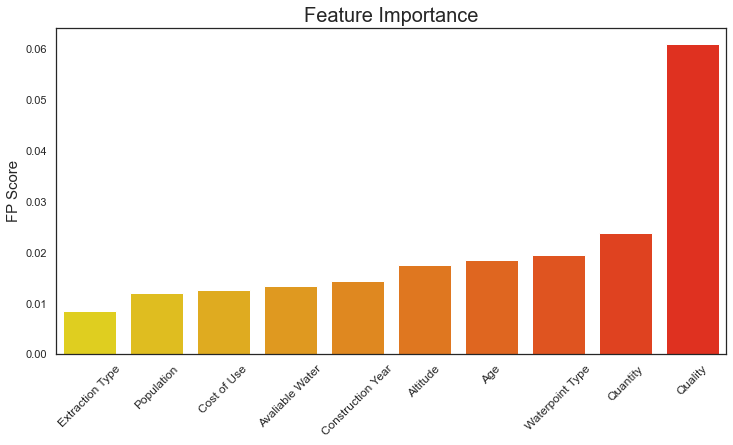

In [220]:
f_importance_rf = sorted(list(zip(X_train.columns, perm_result_rf.importances.ravel())), key=lambda x: x[1])[81:]
x_ax = [_[0] for _ in f_importance_rf]
y_ax = [_[1] for _ in f_importance_rf]

fig, ax = plt.subplots(figsize=(12,6))
sns.barplot(x_ax, y_ax, palette='autumn_r')
plt.xticks(rotation=45)
ax.set_ylabel('FP Score', fontsize=15)
ax.set_title('Feature Importance', fontsize=20)
ax.set_xticklabels(['Extraction Type', 'Population', 'Cost of Use', 
                 'Avaliable Water', 'Construction Year', 'Altitude', 'Age', 
                 'Waterpoint Type', 'Quantity', 'Quality'], fontdict={'fontsize':12});

plt.savefig('../../../data/Feature_Importance_Graph.png')

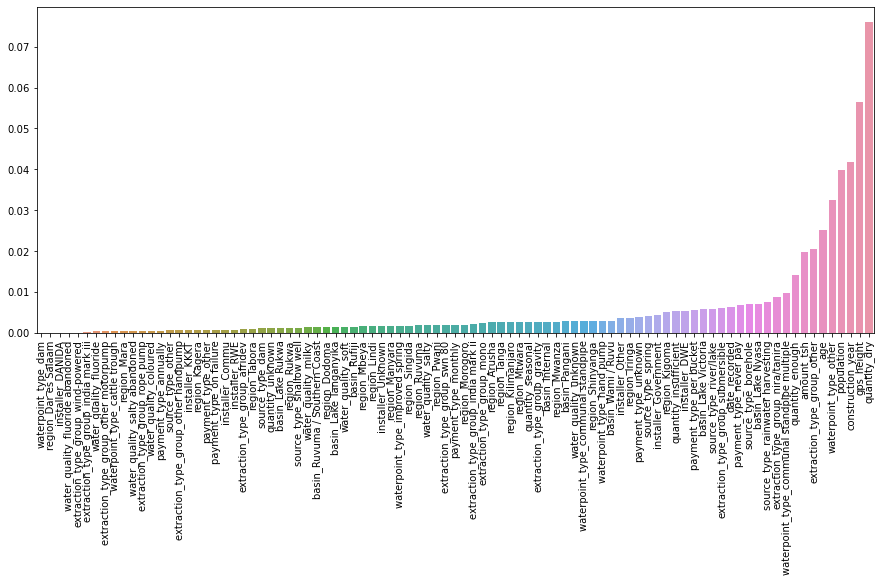

In [118]:
f_importance_xgb = sorted(list(zip(X_train.columns, perm_result_xgb.importances.ravel())), key=lambda x: x[1])
x_ax = [_[0] for _ in f_importance_xgb]
y_ax = [_[1] for _ in f_importance_xgb]

plt.figure(figsize=(15,6))
sns.barplot(x_ax, y_ax)
plt.xticks(rotation=90);

In [59]:
f_imp_df_rf = pd.DataFrame(f_importance_rf)
f_imp_df_xgb = pd.DataFrame(f_importance_xgb)

In [60]:
perm_droplist_rf = list(f_imp_df_rf.loc[f_imp_df_rf[1]<0.01][0])
perm_droplist_xgb = list(f_imp_df_xgb.loc[f_imp_df_xgb[1]<0.01][0])

In [61]:
X_data_7_rf = X_data.drop(columns = perm_droplist_rf, axis=1)
X_data_7_xgb = X_data.drop(columns = perm_droplist_xgb, axis=1)

In [62]:
rf_tester.model_history(X_data_7_rf, notes='Dropped 82 columns with Feature Permutation')
xgb_tester.model_history(X_data_7_xgb, notes='Dropped 81 columns with Feature Permutation')

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering
1,0.824264,0.798608,Removed Date Recorded and Construction Year
2,0.824365,0.798855,Removed Construction Year
3,0.823611,0.797621,Removed basin column
4,0.822633,0.796813,Dropped first columns for OHE'd features
5,0.822372,0.796790,Dropped Age
6,0.792793,0.752952,Dropped 81 columns with Feature Permutation


## Dropping All Negative Error

In [63]:
perm_droplist_2_rf = list(f_imp_df_rf.loc[f_imp_df_rf[1]<0][0])

In [64]:
X_data_8_rf = X_data.drop(columns = perm_droplist_2_rf, axis=1)

In [65]:
rf_tester.model_history(X_data_8_rf, notes='Dropped Negative Error cols w/ FP')

,f1 score,accuracy_score,Notes
0,0.827040,0.797262,Base model with standard feature engineering
1,0.826764,0.796431,Removed Date Recorded and Construction Year
2,0.826684,0.795578,Removed Construction Year
3,0.826273,0.795735,Removed basin column
4,0.765611,0.754411,Replaced Extraction Group with Extraction Type
5,0.824732,0.796857,Dropped first columns for OHE'd features
6,0.826692,0.795623,Dropped Age
7,0.797599,0.762110,Dropped 82 columns with Feature Permutation
8,0.826621,0.796207,Dropped Negative Error cols w/ FP


## Dropping all columns with a FP score under 0.001

In [68]:
perm_droplist_3_rf = list(f_imp_df_rf.loc[f_imp_df_rf[1]<0.001][0])
perm_droplist_3_xgb = list(f_imp_df_xgb.loc[f_imp_df_xgb[1]<0.001][0])

In [69]:
X_data_9_rf = X_data.drop(columns = perm_droplist_3_rf, axis=1)
X_data_9_xgb = X_data.drop(columns = perm_droplist_3_xgb, axis=1)

In [70]:
rf_tester.model_history(X_data_9_rf, notes = 'Dropped all columns with a FP score under 0.001')
xgb_tester.model_history(X_data_9_xgb, notes = 'Dropped all columns with a FP score under 0.001')

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering
1,0.824264,0.798608,Removed Date Recorded and Construction Year
2,0.824365,0.798855,Removed Construction Year
3,0.823611,0.797621,Removed basin column
4,0.822633,0.796813,Dropped first columns for OHE'd features
5,0.822372,0.796790,Dropped Age
6,0.792793,0.752952,Dropped 81 columns with Feature Permutation
7,0.823631,0.798563,Dropped all columns with a FP score under 0.001


## SMOTE-ing in more data

In [71]:
from imblearn.over_sampling import SMOTE

In [72]:
smote = SMOTE(random_state=1)
X_data_10, y_data_10 = smote.fit_sample(X_data, y)

In [73]:
rf_tester.model_history(X=X_data_10, y_new=y_data_10, notes= 'SMOTE-ed in more dummy data')
xgb_tester.model_history(X=X_data_10, y_new=y_data_10, notes= 'SMOTE-ed in more dummy data')

/Applications/Utilities/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Applications/Utilities/anaconda3/lib/python3.8/site-packages/sklearn/mod

,f1 score,accuracy_score,Notes
0,0.825515,0.800606,Base model with standard feature engineering
1,0.824264,0.798608,Removed Date Recorded and Construction Year
2,0.824365,0.798855,Removed Construction Year
3,0.823611,0.797621,Removed basin column
4,0.822633,0.796813,Dropped first columns for OHE'd features
5,0.822372,0.796790,Dropped Age
6,0.792793,0.752952,Dropped 81 columns with Feature Permutation
7,0.823631,0.798563,Dropped all columns with a FP score under 0.001
8,0.807588,0.797711,SMOTE-ed in more dummy data


In [159]:
xgb_tester.df = xgb_tester.df.rename(index={0: 'Dataset 1', 1:2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9})

In [160]:
xgb_tester.df

,f1 score,accuracy_score,Notes
Dataset 1,0.825515,0.800606,Base model with standard feature engineering
2,0.824264,0.798608,Removed Date Recorded and Construction Year
3,0.824365,0.798855,Removed Construction Year
4,0.823611,0.797621,Removed basin column
5,0.822633,0.796813,Dropped first columns for OHE'd features
6,0.822372,0.796790,Dropped Age
7,0.792793,0.752952,Dropped 81 columns with Feature Permutation
8,0.823631,0.798563,Dropped all columns with a FP score under 0.001
9,0.807588,0.797711,SMOTE-ed in more dummy data
